# Streaming Data

In [1]:
%load_ext autoreload

In [2]:
import requests
import numpy as np
import pandas as pd
import gcsfs
import joblib
from google.cloud import storage
import datetime as dt
import matplotlib.pyplot as plt
import dill

In [3]:
def to_readable_datetime(x):
    from datetime import datetime
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

In [10]:
df = pd.read_csv("gcs://wagon-data-750-btc-sent-fc/input_data/input_data_1.csv",
                 index_col=0,
                 parse_dates=True)

In [12]:
df.tail()

,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,miners-revenue,...,tweets_sent,reddit_crypto_sent,reddit_econ_sent,volume_gross,crypto_pos,crypto_neg,crypto_neu,econ_pos,econ_neg,econ_neu
2021-11-18,2054.611695,2.267415e+13,7.682603e+07,2.437422,2.814664,1.270386,275592.333333,725020.000000,7.297222,5.265043e+07,...,-0.191667,0.129760,0.164820,3.137042e+09,0.145112,0.081628,0.773259,0.130400,0.148810,0.720790
2021-11-19,2078.240876,2.267415e+13,7.692242e+07,2.423386,3.531133,1.275837,262180.666667,678741.666667,7.027778,4.966713e+07,...,0.155357,0.058168,0.069516,2.119749e+09,0.085474,0.135326,0.779201,0.125548,0.184152,0.690301
2021-11-20,2078.240876,2.267415e+13,7.701882e+07,2.409351,4.247603,1.275837,248769.000000,632463.333333,6.758333,4.966713e+07,...,0.466667,0.083604,0.014180,8.896024e+08,0.085734,0.178020,0.736247,0.127368,0.070532,0.802100
2021-11-21,2078.240876,2.267415e+13,7.711521e+07,2.409351,4.247603,1.275837,248769.000000,586185.000000,6.758333,4.966713e+07,...,-0.022500,0.173188,0.206028,7.894335e+08,0.203692,0.095910,0.700399,0.195318,0.055419,0.749263
2021-11-22,2078.240876,2.267415e+13,7.711521e+07,2.409351,4.247603,1.275837,248769.000000,586185.000000,6.758333,4.966713e+07,...,0.235000,0.159344,0.069456,1.823717e+09,0.103129,0.098261,0.798611,0.140787,0.260983,0.598230


# NLP samples

In [185]:
storage_client = storage.Client()

# Note: Client.list_blobs requires at least package version 1.17.0.
blobs = storage_client.list_blobs("wagon-data-750-btc-sent-fc",
                                  prefix=f"sent_data/tweet_inflation")
blob_list = [blob.name for blob in blobs]
blob_list.sort()

In [210]:
out_df = pd.DataFrame()

In [193]:
blob_list[-45]

'sent_data/tweet_inflation_2021-11-22T00:00:00.000Z_20.csv'

In [194]:
temp_df = pd.read_csv(f"gcs://wagon-data-750-btc-sent-fc/{blob_list[-45]}",
                          index_col=0,
                          parse_dates=True)

In [209]:
temp_df.iloc[[6]]

,date,text,positive,negative,neutral
6,2021-11-21T00:00:00.000Z,we are in a recession,0.030475,0.73442,0.235105


In [ ]:
tweet

In [373]:
text_list = ["BOOM President Biden attacks inflation crisis by freeing up gridlocked ports in Los Angeles! CEO of Walmart 'I would like to give the administration credit for helping get the ports open 24 hours a day RT if you would like to THANK @JoeBiden too",
            "The U.S. Dollar is a shitcoin!!!!"]

In [377]:
pd.read_csv("gcs://wagon-data-750-btc-sent-fc/sent_data/bert_test_0.csv").loc[4]

Unnamed: 0                                   4
date                       2021-11-22 02:30:01
text          The U.S. dollar is a shitcoin!!!
positive                              0.018965
negative                              0.874369
neutral                               0.106666
Name: 4, dtype: object

text          The U.S. dollar is a shitcoin!!!
positive                              0.018965
negative                              0.874369
neutral                               0.106666

In [353]:
url = https://cloudsentiment-gijujv7fiq-ew.a.run.app/bert?

Object `bert` not found.


In [370]:
url = "https://cloudsentiment-gijujv7fiq-ew.a.run.app/bert"

In [366]:
params = {"date_list" : [1,2],
         "text_list" : text_list}

In [374]:
request = requests.get(url = url, params = params)

In [372]:
request.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

# Reddit Streaming

In [ ]:
file_name = "../keys.json"
with open(file_name, "r") as key_file:
    keys = json.load(key_file)

In [ ]:
# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth(keys['REDDIT_SCRIPT'], keys["REDDIT_TOKEN"])

# here we pass our login method (password), username, and password
data = {
    'grant_type': 'password',
    'username': keys['REDDIT_USERNAME'],
    'password': keys['REDDIT_PASSWORD']
}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}

# send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth,
                    data=data,
                    headers=headers)

# convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

In [ ]:
crypto_url = "https://oauth.reddit.com/r/CryptoCurrency/top/?sort=top&t=day"

In [ ]:
crypto_req = requests.get(crypto_url, headers=headers)

In [ ]:
reddit_crypto_df = pd.DataFrame()
for post in res.json()['data']['children']:
    reddit_crypto_df = reddit_crypto_df.append(
        {
            'date': post["data"]["created_utc"],
            'subreddit': post['data']['subreddit'],
            'title': post['data']['title'],
            'selftext': post['data']['selftext'],
            'upvote_ratio': post['data']['upvote_ratio'],
            'ups': post['data']['ups'],
            'downs': post['data']['downs'],
            'score': post['data']['score']
        },
        ignore_index=True)

In [ ]:
reddit_crypto_df["date"] = reddit_crypto_df["date"].map(to_readable_datetime)

In [ ]:
econ_url = "https://oauth.reddit.com/search?q=economy+OR+recession+OR+inflation+OR+shutdown+OR+infrastructure+OR+market+OR+retirement&restrict_sr=&sort=top&t=day"

In [ ]:
res = requests.get(econ_url, headers=headers)

reddit_df = pd.DataFrame()
for post in res.json()['data']['children']:
    reddit_df = reddit_df.append(
        {
            'date': post["data"]["created_utc"],
            'subreddit': post['data']['subreddit'],
            'title': post['data']['title'],
            'selftext': post['data']['selftext'],
            'upvote_ratio': post['data']['upvote_ratio'],
            'ups': post['data']['ups'],
            'downs': post['data']['downs'],
            'score': post['data']['score']
        },
        ignore_index=True)
reddit_econ_df["date"] = reddit_econ_df["date"]

In [ ]:
reddit_df

In [ ]:
econ_bert = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/econ_bert.csv")[[
        "date", "positive", "negative", "neutral"
    ]]

In [ ]:
crypto_bert["compound"]

In [ ]:
econ_bert["compound"] = (econ_bert.positive - econ_bert.negative) / (
    econ_bert.positive + econ_bert.negative)

In [ ]:
econ_bert.columns = ["econ_pos", "econ_neg", "econ_neu", "econ_compound"]

In [ ]:
econ_bert.set_index("date", inplace=True)

In [ ]:
econ_bert.index = pd.to_datetime(econ_bert.index)

In [ ]:
crypto_bert.index = pd.to_datetime(crypto_bert.index)

In [ ]:
df_merge_two.columns

In [ ]:
df_merge_one = pd.merge(df,
                        crypto_bert[["crypto_pos", "crypto_neg",
                                     "crypto_neu"]],
                        how="left",
                        left_index=True,
                        right_index=True)

In [ ]:
df_merge_two = pd.merge(df_merge_one,
                        econ_bert[["econ_pos", "econ_neg", "econ_neu"]],
                        how="left",
                        left_index=True,
                        right_index=True)

In [ ]:
df_merge_two

In [ ]:
crypto_bert.to_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/crypto_bert.csv")

In [ ]:
econ_bert.to_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/econ_bert.csv")

In [ ]:
df_merge_two.to_csv("gs://wagon-750-btc-sent-fc/input_data/input_data_1.csv")

In [ ]:
economy_keywords = [
    "economy", "recession", "inflation", "shutdown", "infrastructure",
    "market", "retirement"
]

In [ ]:
econ_string = "+OR+".join(economy_keywords)

In [ ]:
econ_string

In [ ]:
econ_bert = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/econ_bert.csv",
    index_col=0,
    parse_dates=True)

# Twitter collating

In [74]:
storage_client = storage.Client()

# Note: Client.list_blobs requires at least package version 1.17.0.
blobs = storage_client.list_blobs("wagon-data-750-btc-sent-fc",
                                  prefix=f"sent_data/tweet_reccession")
blob_list = [blob.name for blob in blobs]
blob_list.sort()

In [75]:
blob_list

[]

In [ ]:
inflation_bert = pd.DataFrame()
for blob in blob_list:
    temp_df = pd.read_csv(f"gcs://wagon-data-750-btc-sent-fc/{blob}",
                          index_col=0,
                          parse_dates=True)
    inflation_bert = inflation_bert.append(temp_df)

In [ ]:
inflation_bert["date"] = pd.to_datetime(inflation_bert["date"]).dt.date

In [ ]:
inflation_grouped = inflation_bert.groupby("date").mean()

In [ ]:
inflation_grouped.columns = ["inflation_pos", "inflation_neg", "inflation_neu"]

In [ ]:
df_merge_three = pd.merge(df_merge_two,
                          inflation_grouped,
                          how="left",
                          left_index=True,
                          right_index=True)

In [ ]:
df_merge_three.to_csv("gs://wagon-750-btc-sent-fc/input_data/input_data_2.csv")

# Sentiment DF for Website

In [ ]:
sent_df = df_merge_three[[
    "reddit_econ_sent", "reddit_crypto_sent", "tweets_sent"
]]

In [ ]:
inflation_bert["compound"] = (inflation_bert.positive - inflation_bert.negative
                              ) / (inflation_bert.positive +
                                   inflation_bert.negative)

In [ ]:
inflation_grouped = inflation_bert.groupby("date").mean()

In [ ]:
inflation_grouped.columns = [
    "inflation_pos", "inflation_neg", "inflation_neu", "inflation_compound"
]

In [ ]:
inflation_grouped.to_csv(
    "gs://wagon-data-750-btc-sent-fc/sent_processed/inflation_bert.csv")

In [ ]:
sent_df_1 = sent_df.merge(inflation_grouped["inflation_compound"],
                          left_index=True,
                          right_index=True).merge(
                              econ_bert[["econ_compound"]],
                              left_index=True,
                              right_index=True).merge(
                                  crypto_bert[["crypto_compound"]],
                                  left_index=True,
                                  right_index=True)

In [ ]:
sent_df_1.columns

In [ ]:
sent_df_1.drop("reddit_econ_sent", axis=1, inplace=True)
sent_df_1.drop("reddit_crypto_sent", axis=1, inplace=True)

In [ ]:
sent_df_1["econ_compound"] = (sent_df_1["tweets_sent"] +
                              sent_df_1["econ_compound"]) / 2

In [ ]:
sent_df_1.drop("tweets_sent", axis=1, inplace=True)

In [ ]:
sent_df_1.to_csv(
    "gcs://wagon-data-750-btc-sent-fc/website_data/sent_data_1.csv")

In [ ]:
sent_df_1.merge(
    df_merge_two["volume_gross"], left_index=True, right_index=True).to_csv(
        "gcs://wagon-data-750-btc-sent-fc/website_data/chart_data_1.csv")

In [347]:
pd.read_csv("gcs://wagon-data-750-btc-sent-fc/sent_processed/inflation_bert.csv").iloc[-38:-8].mean()

/tmp/ipykernel_26579/3535829392.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.read_csv("gcs://wagon-data-750-btc-sent-fc/sent_processed/inflation_bert.csv").iloc[-38:-8].mean()


inflation_pos         0.110507
inflation_neg         0.399176
inflation_neu         0.490317
inflation_compound   -0.396558
dtype: float64

In [345]:
pd.read_csv("gcs://wagon-data-750-btc-sent-fc/sent_processed/crypto_bert.csv").iloc[-30:]

,date,crypto_pos,crypto_neg,crypto_neu,crypto_compound
2153,2021-10-24,0.144458,0.137841,0.717701,0.023441
2154,2021-10-25,0.160414,0.164780,0.674805,-0.013425
2155,2021-10-26,0.166129,0.177104,0.656766,-0.031975
2156,2021-10-27,0.084918,0.157990,0.757092,-0.300821
2157,2021-10-28,0.098170,0.156627,0.745204,-0.229427
2158,2021-10-29,0.163806,0.185716,0.650478,-0.062688
2159,2021-10-30,0.110630,0.089443,0.799927,0.105892
2160,2021-10-31,0.065225,0.081533,0.853242,-0.111121
2161,2021-11-01,0.178182,0.067171,0.754647,0.452454
2162,2021-11-02,0.225506,0.059151,0.715343,0.584405


# Preproc Pipeline

In [5]:
from Main_package.RNN_model.data import clean_features, clean_test_features

2021-12-01 16:30:26.787751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 16:30:26.787800: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [237]:
big_df = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/input_data/input_data_1.csv",
    index_col=0,
    parse_dates=True)

In [7]:
pipeline = clean_features(big_df)

In [48]:
fake_1 = pd.read_csv("gs://wagon-data-750-btc-sent-fc/input_data/fake_1",
                     index_col=0,
                     parse_dates=True)

In [49]:
clean_test_features(fake_1)

,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,miners-revenue,...,S&P U.S. TIPS 7-10 Year Index (USD),S&P U.S. Treasury Bond 3-5 Year Index,S&P U.S. TIPS 3-5 Year Index (USD),S&P U.S. TIPS 1-3 Year Index (USD),S&P U.S. TIPS 5-7 Year Index (USD),S&P U.S. Treasury Bill 6-9 Month Index,tweets_sent,reddit_crypto_sent,reddit_econ_sent,volume_gross
2021-08-25,-0.360762,0.861678,1.484932,0.663352,-2.406838,0.372842,-0.087721,0.715103,-1.810167,1.380860,...,2.015781,2.045013,1.966391,1.226304,-0.546254,0.923562,1.289873,0.009306,-0.657061,20.612995
2021-08-26,-0.319383,0.877497,1.488754,0.683136,-1.972124,0.195304,-0.376206,0.655029,-1.692510,1.350133,...,2.008967,2.046472,1.962435,1.226304,-0.403878,1.883524,3.509417,0.060181,-0.711166,20.825791
2021-08-27,-0.278358,0.892949,1.491011,0.702777,-1.616306,0.011533,-0.682608,0.257137,-1.579076,1.318399,...,2.067172,2.091647,2.027560,1.226304,-0.403878,-0.618229,0.266756,0.094336,-0.612330,20.563803
2021-08-28,-0.188108,0.908052,1.493268,0.682938,-1.624699,0.265408,-1.009301,-0.177081,-1.469574,1.297372,...,2.074213,2.101350,2.031989,1.226304,1.015435,1.268133,2.943081,0.147695,-0.699410,19.986069
2021-08-29,-0.099520,0.908052,1.495523,0.662954,-1.633128,0.507538,-0.625775,-0.654931,-1.212013,1.275878,...,2.081251,2.111049,2.036416,1.226304,-0.403878,0.545835,2.014416,0.201053,-0.702000,20.331581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17,0.413307,1.076333,1.555998,0.785842,-3.293221,1.109824,0.416290,1.325137,-0.797349,1.544637,...,2.318785,2.537117,2.182636,1.229455,-0.377992,1.198626,0.174493,0.323869,-0.677891,21.638166
2021-11-18,0.468953,1.076333,1.553682,0.770169,-2.715368,1.132334,0.181801,1.360443,-0.911924,1.491252,...,2.302427,2.531405,2.171933,1.231031,-1.594652,0.764770,1.357496,0.323869,-0.555708,21.866546
2021-11-19,0.523962,1.076333,1.560422,0.754406,-2.269287,1.154748,-0.064390,1.046534,-1.030810,1.434753,...,2.224131,2.442695,2.113888,1.231031,0.561314,-0.276274,0.357381,0.323869,-0.620867,21.474563
2021-11-20,0.523962,1.076333,1.567154,0.738551,-1.905901,1.154748,-0.323510,0.710450,-1.154344,1.434753,...,2.199696,2.425485,2.084196,1.229455,2.495397,0.093599,-0.223311,0.323869,-0.686026,20.606285


# Placeholder prediction array

In [ ]:
url = "https://cloudsentiment-gijujv7fiq-ew.a.run.app/predict"

In [109]:
pred_df = df.interpolate(method='linear',axis=0)
pred_df['volume_gross'] = np.log(pred_df['volume_gross'])

In [235]:
pred_df.shape[0]

1972

In [244]:
pred_mape_4 = df[["volume_gross"]].iloc[91:]
pred_mape_4.columns = ["volume_actual"]

In [245]:
pred_mape_4.loc[dt.datetime(2021, 11,
                                    23)] = real_volume.loc[dt.datetime(
                                        2021, 11, 23)]["volume_gross"]

In [122]:
#pred_mape_2.drop(dt.datetime(2021, 10,23), inplace = True)

In [247]:
pred_mape_4.head(1)

,volume_actual
2016-09-29,4.916548e+06


In [250]:
pred_mape_4.shape

(1882, 1)

In [351]:
pred_df.iloc[-90:].to_csv(f"gcs://wagon-data-750-btc-sent-fc/input_data/pred_1.csv")

In [238]:
pred_df.shape[0]-90

1882

In [380]:
#for i in range(1, pred_df.shape[0]-90):
#        pred_df.iloc[-(90+i):-i].to_csv(
#        f"gcs://wagon-data-750-btc-sent-fc/input_data/pred_{i+1}.csv")  #

In [240]:
pd.read_csv("gcs://wagon-data-750-btc-sent-fc/input_data/pred_1882")

,Unnamed: 0,n-transactions-per-block,difficulty,utxo-count,mvrv,nvt,avg-block-size,n-transactions-excluding-popular,n-unique-addresses,median-confirmation-time,...,tweets_sent,reddit_crypto_sent,reddit_econ_sent,volume_gross,crypto_pos,crypto_neg,crypto_neu,econ_pos,econ_neg,econ_neu
0,2016-07-01,1414.325108,2.094532e+11,3.976440e+07,1.896975,7.678641,0.736557,202414.000000,356294.000000,8.166667,...,-0.283333,0.102044,0.078542,16.018265,0.086713,0.103169,0.810118,0.140822,0.150504,0.708674
1,2016-07-02,1282.250216,2.094880e+11,3.979276e+07,1.890508,7.786408,0.675603,205482.000000,348963.000000,7.988889,...,0.059091,-0.005800,-0.034312,15.728642,0.094833,0.084204,0.820962,0.085085,0.214815,0.700100
2,2016-07-03,1150.175325,2.095228e+11,3.982112e+07,1.884042,7.894175,0.614649,208550.000000,360712.666667,7.811111,...,0.000000,0.015013,0.020940,15.945403,0.126766,0.109568,0.763666,0.064866,0.215263,0.719870
3,2016-07-04,1277.952597,2.095577e+11,3.984947e+07,1.877575,8.001942,0.675615,211618.000000,372462.333333,7.633333,...,0.000000,0.040985,0.047200,15.544455,0.074235,0.126823,0.798941,0.060054,0.168777,0.771169
4,2016-07-05,1405.729870,2.108381e+11,3.988524e+07,1.843449,7.499257,0.736582,212097.000000,384212.000000,8.005556,...,0.121429,0.082286,-0.155104,15.749834,0.240535,0.064048,0.695417,0.100041,0.219965,0.679994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2016-09-24,1251.652150,2.309643e+11,4.186702e+07,1.614089,7.207065,0.634798,222425.333333,368915.000000,8.905556,...,0.011111,0.112856,-0.022875,14.982902,0.177192,0.070919,0.751889,0.053470,0.207262,0.739269
86,2016-09-25,1057.524324,2.360958e+11,4.187965e+07,1.613247,7.820541,0.570906,224970.666667,389109.666667,7.927778,...,0.000000,0.094548,0.128692,14.929592,0.248131,0.023046,0.728822,0.053173,0.102561,0.844266
87,2016-09-26,1234.284234,2.412272e+11,4.188610e+07,1.612405,8.434017,0.641373,227516.000000,409304.333333,6.950000,...,0.025000,0.063968,-0.132363,15.445899,0.190115,0.096993,0.712891,0.041662,0.280505,0.677833
88,2016-09-27,1411.044144,2.412272e+11,4.189255e+07,1.617083,7.122488,0.711839,230773.000000,429499.000000,7.750000,...,-0.083333,0.016500,0.014442,15.477224,0.101275,0.124623,0.774102,0.094356,0.238900,0.666744


In [379]:
predict("pred_1")

1682710000.0

In [115]:
fs = gcsfs.GCSFileSystem()
with fs.open("gcs://wagon-data-750-btc-sent-fc/model/RNN_2_MAPE_best.joblib") as f:
    model = joblib.load(f)

In [248]:
def predict(file_name, shape=(1, 90, 67)):
    """model_name is a string - "model_name.joblib"
    date is also a string - in the format "yyyy_mm_dd"
    shape is a 3 part tuple with the input dimensions of the model"""
    X_pred = np.zeros((1, 90, 67))
    X_df = pd.read_csv(
        f"gcs://wagon-data-750-btc-sent-fc/input_data/{file_name}",
        index_col=0,
        parse_dates=True)
    X_pred[0] = X_df
    y_pred = model.predict_on_batch(X_pred)
    return np.exp(y_pred[0][0])

In [249]:
predict("pred_170")

949266240.0

In [251]:
predictions = []
for i in range(1, 1883):
    predictions.append(predict(file_name=f"pred_{i}"))

In [259]:
pred_mape_4["volume_pred"] = list(reversed(predictions))

In [253]:
pred_mape_4.shape

(1882, 2)

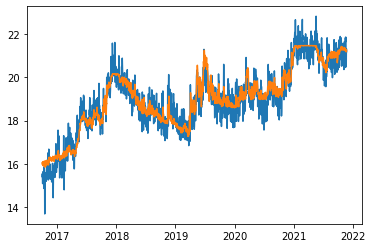

In [316]:
plt.plot(np.log(pred_mape_4["volume_actual"]))
plt.plot(np.log(pred_mape_4["volume_pred"]))

In [261]:
pred_mape_4["pred_norm"] = (pred_mape_4["volume_pred"] -
        np.mean(pred_mape_4["volume_pred"])) / np.std(
            pred_mape_4["volume_pred"])
pred_mape_4["actual_norm"] = (pred_mape_4["volume_actual"] -
          np.mean(pred_mape_4["volume_actual"])) / np.std(
              pred_mape_4["volume_actual"])

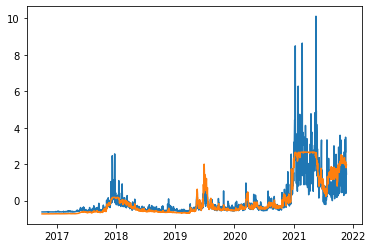

In [263]:
plt.plot(pred_mape_4["actual_norm"])
plt.plot(pred_mape_4["pred_norm"])

In [ ]:
np.sqrt(mse(pred_mape_4["volume_actual"], pred_mape_4["volume_pred"]))

In [ ]:
mae(pred_mape_4["volume_actual"], pred_mape_4["volume_actual_y"])

In [317]:
pred_mape_2

,volume_actual,volume_pred,actual_norm,pred_norm
2021-10-24,1.037417e+09,1.722125e+09,-0.853389,-0.540968
2021-10-25,1.311339e+09,1.731106e+09,-0.443150,-0.435833
2021-10-26,1.502727e+09,1.724136e+09,-0.156518,-0.517422
2021-10-27,2.245568e+09,1.802666e+09,0.955996,0.401918
2021-10-28,2.329611e+09,1.844662e+09,1.081862,0.893560
2021-10-29,1.908097e+09,1.984253e+09,0.450583,2.527738
2021-10-30,8.365006e+08,1.960227e+09,-1.154291,2.246468
2021-10-31,1.023331e+09,1.812412e+09,-0.874485,0.516017
2021-11-01,1.432807e+09,1.737732e+09,-0.261233,-0.358261
2021-11-02,1.715945e+09,1.753376e+09,0.162806,-0.175111


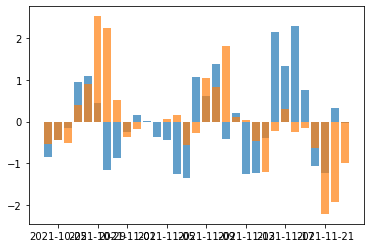

In [320]:
plt.bar(predict_placeholder.index, pred_mape_2["actual_norm"], alpha = 0.7)
plt.bar(predict_placeholder.index, pred_mape_2["pred_norm"], alpha = 0.7)
plt.show()

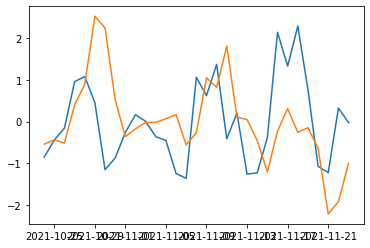

In [315]:
plt.plot(pred_mape_2["actual_norm"])
plt.plot(pred_mape_2["pred_norm"])

In [69]:
#predict_placeholder.to_csv(
#   "gcs://wagon-data-750-btc-sent-fc/website_data/pred_12_02.csv")

In [278]:
pred_mape_2 = pd.read_csv("gcs://wagon-data-750-btc-sent-fc/website_data/pred_12_02_1.csv",
            index_col=0,
            parse_dates=True)

In [283]:
pred_mape_2.index

DatetimeIndex(['2021-10-24', '2021-10-25', '2021-10-26', '2021-10-27',
               '2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31',
               '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
               '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08',
               '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-20',
               '2021-11-21', '2021-11-22', '2021-11-23'],
              dtype='datetime64[ns]', freq=None)

In [285]:
reverse = pd.Series(reversed(pred_mape_2["volume_pred"]))#
reverse.index = pred_mape_2.index

In [286]:
pred_mape_2["volume_pred"] = reverse

In [313]:
pred_mape_2["pred_norm"] = (pred_mape_2["volume_pred"] -
        np.mean(pred_mape_2["volume_pred"])) / np.std(
            pred_mape_2["volume_pred"])

In [314]:
pred_mape_2["actual_norm"] = (pred_mape_2["volume_actual"] -
          np.mean(pred_mape_2["volume_actual"])) / np.std(
              pred_mape_2["volume_actual"])

(15.0, 25.0)

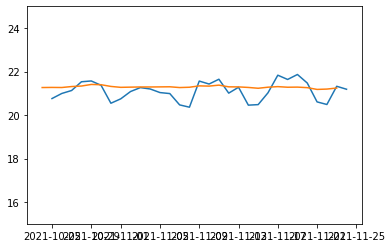

In [312]:

plt.plot(np.log(pred_mape_2["volume_actual"]))
plt.plot(np.log(pred_mape_2["volume_pred"]))
plt.ylim((15,25))

In [177]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [ ]:
pred_mape_2[]

In [290]:
series = pred_mape_2["volume_actual"]

In [291]:
series.index = series.index + dt.timedelta(days=1)

In [292]:
pred_mape_3 = pred_mape_2.merge(series, how = "outer", left_index = True, right_index = True)

In [293]:
pred_mape_3.drop(dt.datetime(2021,11,24), inplace = True)

In [294]:
np.sqrt(mse(pred_mape_3["volume_actual_x"], pred_mape_3["volume_actual_y"]))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [174]:
mae(pred_mape_3["volume_actual_x"], pred_mape_3["volume_actual_y"])

558340680.9362983

In [297]:
mape(pred_mape_3["volume_actual_x"], pred_mape_3["volume_actual_y"])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [296]:
np.sqrt(mse(pred_mape_2["volume_actual"], pred_mape_2["volume_pred"]))

679980547.910075

In [295]:
mae(pred_mape_2["volume_actual"], pred_mape_2["volume_pred"])

568401534.4722388

In [298]:
mape(pred_mape_2["volume_actual"], pred_mape_2["volume_pred"])

0.4733977163898747

In [299]:
np.sqrt(mse(pred_mape_2["actual_norm"], pred_mape_2["pred_norm"]))

1.3064852176704103

In [181]:
mape(pred_mape_2["actual_norm"], pred_mape_2["pred_norm"])

2.6792077831631125

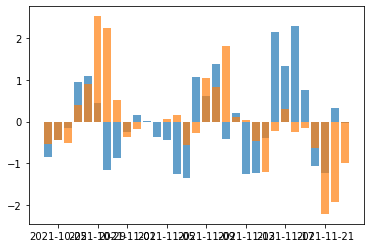

In [319]:
plt.bar(predict_placeholder.index, pred_mape_2["actual_norm"], alpha = 0.7)
plt.bar(predict_placeholder.index, pred_mape_2["pred_norm"], alpha = 0.7)
plt.show()

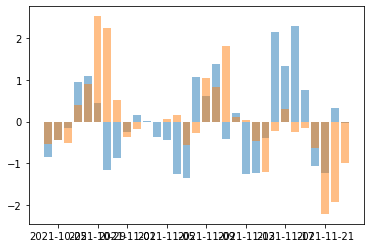

In [318]:
plt.bar(pred_mape_2.index, pred_mape_2["actual_norm"], alpha = 0.5)
plt.bar(pred_mape_2.index, pred_mape_2["pred_norm"], alpha = 0.5)
plt.show()

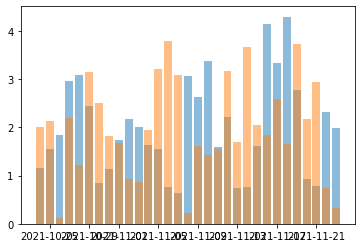

In [98]:
plt.bar(predict_placeholder.index, actual+2, alpha = 0.5)
plt.bar(predict_placeholder.index, pred+2, alpha = 0.5)
plt.show()

In [232]:
pred_mape_2

,volume_actual,volume_pred,actual_norm,pred_norm
2021-10-24,1.037417e+09,1.682710e+09,-0.853389,-1.002396
2021-10-25,1.311339e+09,1.604116e+09,-0.443150,-1.922484
2021-10-26,1.502727e+09,1.579045e+09,-0.156518,-2.215992
2021-10-27,2.245568e+09,1.713455e+09,0.955996,-0.642463
2021-10-28,2.329611e+09,1.755910e+09,1.081862,-0.145453
2021-10-29,1.908097e+09,1.746297e+09,0.450583,-0.257983
2021-10-30,8.365006e+08,1.794984e+09,-1.154291,0.311983
2021-10-31,1.023331e+09,1.748894e+09,-0.874485,-0.227585
2021-11-01,1.432807e+09,1.665131e+09,-0.261233,-1.208193
2021-11-02,1.715945e+09,1.729422e+09,0.162806,-0.455539


In [302]:
pred_mape_2.to_csv(
   "gcs://wagon-data-750-btc-sent-fc/website_data/pred_12_02_1.csv")

## Getting actual value for the 23rd

In [4]:
real_volume = pd.read_csv("../raw_data/coinbase_2021_11.csv")

In [5]:
real_volume.set_index("time", inplace=True)

In [6]:
real_volume.index = pd.to_datetime(real_volume.index)

In [9]:
real_volume.tail()

,close,high,low,open,volumefrom,volumeto,conversionType,conversionSymbol,mean_price,volumefrom_USD,volume_net,volume_gross
time,,,,,,,,,,,,
2021-11-27,54759.05,55316.67,53642.58,53757.67,7897.81,4.316102e+08,force_direct,NaN,54479.625,4.302697e+08,1.340459e+06,8.618799e+08
2021-11-28,57317.17,57490.00,53327.00,54759.05,8220.95,4.518309e+08,force_direct,NaN,55408.500,4.555105e+08,-3.679643e+06,9.073414e+08
2021-11-29,57838.06,58908.27,56730.00,57317.17,13450.66,7.762893e+08,force_direct,NaN,57819.135,7.777055e+08,-1.416266e+06,1.553995e+09
2021-11-30,56987.97,59249.77,55910.33,57838.06,18034.28,1.036531e+09,force_direct,NaN,57580.050,1.038415e+09,-1.883843e+06,2.074946e+09
2021-12-01,58476.44,58602.95,56700.00,56987.97,8886.77,5.086704e+08,force_direct,NaN,57651.475,5.123354e+08,-3.664970e+06,1.021006e+09


In [57]:
real_volume.loc[dt.datetime(2021, 11, 22)]["volume_gross"]

1823717234.0226

In [303]:
real_volume.to_csv("gs://wagon-data-750-btc-sent-fc/website_data/actual_for_11.csv")

In [304]:
real_volume.to_csv("../raw_data/actual_for_11.csv")

In [306]:
pred_mape_2.to_csv("../raw_data/prediction_fin.csv")

# Text-box stuff

In [211]:
tweet_df = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/tweet_data/inflation_2021-11-22T00:00:00.000Z"
)

In [212]:
inflation_tweet_text = tweet_df["clean_tweet"]

In [231]:
tweet_df.iloc[[-1]]

,Unnamed: 0,tweet,tweet_date,topic,tweet_id,clean_tweet,title
62,96,RT @joncoopertweets: BOOM – President Biden at...,2021-11-23T00:00:00.000Z,inflation,1462933719199715330,rt boom president biden attacks inflation cr...,rt boom president biden attacks inflation cr...


In [ ]:
len(inflation_tweet_text)

In [ ]:
crypto_reddit_df = pd.read_csv(
    "gs://wagon-data-750-btc-sent-fc/raw_data/crypto_reddit.csv")
crypto_reddit_df["date"] = pd.to_datetime(crypto_reddit_df["date"])

In [ ]:
crypto_reddit_df[crypto_reddit_df["date"] > dt.datetime(2021, 11, 22)]["title"]

In [ ]:
crypto_reddit_text = crypto_reddit_df[
    crypto_reddit_df["date"] > dt.datetime(2021, 11, 22)]["title"]
len(crypto_reddit_text)

In [ ]:
econ_reddit_df = pd.read_csv(
    "gcs://wagon-data-750-btc-sent-fc/raw_data/reddit_econ_prelim.csv")

In [ ]:
econ_reddit_df["date"] = econ_reddit_df["date"].map(to_readable_datetime)

In [ ]:
econ_reddit_df["date"] = pd.to_datetime(econ_reddit_df["date"])

In [ ]:
econ_reddit_text = econ_reddit_df[
    econ_reddit_df["date"] > dt.datetime(2021, 11, 22)]["title"]

In [ ]:
len(econ_reddit_text)

In [ ]:
econ_reddit_text[1]

In [ ]:
text_string = " ".join(i for i in econ_reddit_text)

In [ ]:
len(text_string)

In [ ]:
text_string_1 = " ".join(i for i in crypto_reddit_text)

In [ ]:
len(text_string_1)

In [ ]:
text_string_3 = " ".join(i for i in inflation_tweet_text)

In [ ]:
len(text_string_3)

In [ ]:
text_string_4 = text_string_1 + text_string_3 + text_string

In [ ]:
len(text_string_4)

In [ ]:
text_string_4

In [ ]:
text_list = text_string_4.split()

In [ ]:
text_list

In [ ]:
60 * 163

In [ ]:
out_string = ", ".join(text_list)

In [ ]:
out_string[3]

In [ ]:
fs = gcsfs.GCSFileSystem()
with fs.open(
        'wagon-data-750-btc-sent-fc/website_data/word_text_2021_11_22.txt',
        "w") as f:
    f.write(out_string)

In [ ]:
from collections import Counter

In [ ]:
l_sorted = Counter(text_list).most_common()

In [ ]:
l_sorted

In [ ]:
with fs.open(
        'wagon-data-750-btc-sent-fc/website_data/word_text_2021_11_22.txt',
        "rb") as f:
    in_string = f.read().decode()

In [ ]:
import string

In [ ]:
in_string[3]

# BTC DATA

In [ ]:
bitcoin_list = [
    'n-transactions-per-block', 'difficulty', 'utxo-count', 'mvrv', 'nvt',
    'avg-block-size', 'n-transactions-excluding-popular', 'n-unique-addresses',
    'median-confirmation-time', 'miners-revenue', 'mempool-growth',
    'mempool-size', 'blocks-size', 'hash-rate', 'n-transactions-total',
    'avg-confirmation-time', 'nvts', 'transaction-fees-usd', 'active_account'
]

In [ ]:
bitcoin_list

## Glassnode?

In [ ]:
glassnode_url = "https://api.glassnode.com/v2/metrics"

In [ ]:
active_account = "addresses/active_count"

In [ ]:
import tensorflow as tf

In [ ]:
loaded_model = joblib.load(
    tf.io.gfile.GFile(
        "gs://wagon-data-750-btc-sent-fc/model/finbert_token.joblib", "rb"))

In [ ]:
loaded_model

In [ ]:
fs = gcsfs.GCSFileSystem()
with fs.open('wagon-data-750-btc-sent-fc/model/finbert_token.joblib') as f:
    model = joblib.load(f)

In [ ]:
model

In [ ]:
pd.read_csv("gs://wagon-data-750-btc-sent-fc/input_data/test_2021_11_22.csv")